In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import random
from sklearn.metrics import precision_recall_fscore_support
import time
from PIL import Image
from IPython.display import clear_output
import os
import torch.multiprocessing as mp
import sys
sys.path.append('.')  # Adds current directory to Python path
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from hd_computing import HDComputing
from utils import create_position_hvs, create_level_hvs

In [25]:
# Important: Set multiprocessing method BEFORE creating datasets
mp.set_start_method('spawn', force=True)

# Cell 2: Import your dataset class
from dataset import HDCDataset

In [26]:
# Set random seeds for reproducibility
np.random.seed(21)
torch.manual_seed(21)
random.seed(21)

# Hyperparameters
dim = 50                    # Hypervector dimensionality
num_levels = 5              # Number of quantization levels for pixel intensities
batch_size = 64             # Batch size for training and testing
num_epochs = 5              # Number of training epochs
learning_rate = 0.001      # Learning rate for the optimizer (initial before scheduler)
workers = 4                 # Number of workers for the DataLoader
image_resize = (48, 64)   # Resize images to this size
percentage_to_train = 0.01   # Percentage of the dataset to use for training
train_split = 0.8
use_gpu = torch.cuda.is_available()
device = torch.device('cuda' if use_gpu else 'cpu')

In [27]:
# Define the Hyperdimensional Computing class using PyTorch tensors

"""class HDComputing:
    def __init__(self, dim, device):
        self.dim = dim
        self.device = device

    def random_hv(self):
        # Generate a random hypervector with values in {-1, 1}
        hv = torch.randint(0, 2, (self.dim,), device=self.device, dtype=torch.float32)
        hv[hv == 0] = -1
        return hv

    def batch_bind(self, hvs1, hvs2):
        return hvs1 * hvs2  # Or your specific binding operation

    def batch_superpose(self, hvs):
        return torch.sum(hvs, dim=1)

    def permute(self, hv, shifts=1):
        # Circular shift (permutation) to encode position
        return torch.roll(hv, shifts=shifts, dims=0)"""

'class HDComputing:\n    def __init__(self, dim, device):\n        self.dim = dim\n        self.device = device\n\n    def random_hv(self):\n        # Generate a random hypervector with values in {-1, 1}\n        hv = torch.randint(0, 2, (self.dim,), device=self.device, dtype=torch.float32)\n        hv[hv == 0] = -1\n        return hv\n\n    def batch_bind(self, hvs1, hvs2):\n        return hvs1 * hvs2  # Or your specific binding operation\n\n    def batch_superpose(self, hvs):\n        return torch.sum(hvs, dim=1)\n\n    def permute(self, hv, shifts=1):\n        # Circular shift (permutation) to encode position\n        return torch.roll(hv, shifts=shifts, dims=0)'

In [28]:
"""# Function to create level hypervectors for quantized pixel intensities
def create_level_hvs(num_levels, dim, hd):
    level_hvs = {}
    for level in range(num_levels):
        level_hvs[level] = hd.random_hv()
    return level_hvs

# Function to create position hypervectors for each pixel position
def create_position_hvs(num_positions, dim, hd):
    position_hvs = {}
    base_position_hv = hd.random_hv()
    position_hvs[0] = base_position_hv
    for pos in range(1, num_positions):
        position_hvs[pos] = hd.permute(position_hvs[pos - 1])
    return position_hvs

# Function to encode an image into a hypervector
def encode_image(image, position_hvs, level_hvs, hd, num_levels):
    # Flatten the image to a 1D array
    image = image.flatten()
    quantized_levels = torch.round(image * (num_levels)).long() # Quantize pixel intensities for values in [0, 1]
    quantized_levels[quantized_levels == num_levels] = num_levels - 1
    hvs = []
    for pos, level in enumerate(quantized_levels):
        position_hv = position_hvs[pos]
        level_hv = level_hvs[level.item()]
        combined_hv = hd.bind(position_hv, level_hv)
        hvs.append(combined_hv)
    image_hv = hd.superpose(hvs)
    return image_hv"""

'# Function to create level hypervectors for quantized pixel intensities\ndef create_level_hvs(num_levels, dim, hd):\n    level_hvs = {}\n    for level in range(num_levels):\n        level_hvs[level] = hd.random_hv()\n    return level_hvs\n\n# Function to create position hypervectors for each pixel position\ndef create_position_hvs(num_positions, dim, hd):\n    position_hvs = {}\n    base_position_hv = hd.random_hv()\n    position_hvs[0] = base_position_hv\n    for pos in range(1, num_positions):\n        position_hvs[pos] = hd.permute(position_hvs[pos - 1])\n    return position_hvs\n\n# Function to encode an image into a hypervector\ndef encode_image(image, position_hvs, level_hvs, hd, num_levels):\n    # Flatten the image to a 1D array\n    image = image.flatten()\n    quantized_levels = torch.round(image * (num_levels)).long() # Quantize pixel intensities for values in [0, 1]\n    quantized_levels[quantized_levels == num_levels] = num_levels - 1\n    hvs = []\n    for pos, level in 

In [29]:
"""# Optimized HDC encoding functions
def create_level_hvs(num_levels, dim, hd):
    level_hvs = torch.stack([hd.random_hv() for _ in range(num_levels)])
    return {i: hv for i, hv in enumerate(level_hvs)}

def create_position_hvs(num_positions, dim, hd):
    position_hvs = torch.empty((num_positions, dim), dtype=torch.float32)
    position_hvs[0] = hd.random_hv()
    
    for pos in range(1, num_positions):
        position_hvs[pos] = hd.permute(position_hvs[pos - 1])
    
    return {i: hv for i, hv in enumerate(position_hvs)}

def batch_encode_image(images, position_hvs, level_hvs, hd, num_levels):
    # Assume images is a batch of flattened images
    batch_size = images.shape[0]
    quantized_levels = torch.clamp(torch.round(images * num_levels), 0, num_levels - 1).long()
    
    # Create position and level hypervector tensors for the entire batch
    positions = torch.arange(images.shape[1]).repeat(batch_size, 1)
    position_hvs_batch = torch.stack([position_hvs[pos] for pos in positions.flatten()]).view(batch_size, -1, position_hvs[0].shape[0])
    level_hvs_batch = torch.stack([level_hvs[level.item()] for level in quantized_levels.flatten()]).view(batch_size, -1, level_hvs[0].shape[0])
    
    # Batch bind and superpose
    combined_hvs = hd.batch_bind(position_hvs_batch, level_hvs_batch)
    image_hvs = torch.sum(combined_hvs, dim=1)
    
    return image_hvs"""

'# Optimized HDC encoding functions\ndef create_level_hvs(num_levels, dim, hd):\n    level_hvs = torch.stack([hd.random_hv() for _ in range(num_levels)])\n    return {i: hv for i, hv in enumerate(level_hvs)}\n\ndef create_position_hvs(num_positions, dim, hd):\n    position_hvs = torch.empty((num_positions, dim), dtype=torch.float32)\n    position_hvs[0] = hd.random_hv()\n    \n    for pos in range(1, num_positions):\n        position_hvs[pos] = hd.permute(position_hvs[pos - 1])\n    \n    return {i: hv for i, hv in enumerate(position_hvs)}\n\ndef batch_encode_image(images, position_hvs, level_hvs, hd, num_levels):\n    # Assume images is a batch of flattened images\n    batch_size = images.shape[0]\n    quantized_levels = torch.clamp(torch.round(images * num_levels), 0, num_levels - 1).long()\n    \n    # Create position and level hypervector tensors for the entire batch\n    positions = torch.arange(images.shape[1]).repeat(batch_size, 1)\n    position_hvs_batch = torch.stack([position

In [30]:
# Custom Dataset Class to load and augment the data
"""
class HDCDataset():
    def __init__(self, path, image_list, transformations, position_hvs, level_hvs, hd, num_levels):
        self.image_list = image_list
        self.targets = image_list['classname']
        self.transformations = transformations
        self.position_hvs = position_hvs
        self.level_hvs = level_hvs
        self.hd = hd
        self.num_levels = num_levels
        self.path = path

        self.data = self.load_data()
        self.transformed_data = self.transform()
        self.hv_data = self.hdc_encode()

    def load_data(self):
        data = []
        for i in range(len(self.image_list)):
            image_path = self.path + f'c{self.image_list['classname'][i]}/' + self.image_list['img'][i]
            image = Image.open(image_path)
            transform_to_tensor = v2.Compose([
                v2.Resize(image_resize),  # Resize the image to a fixed size
                v2.ToImage(),  # Ensures the input is treated as an image
                v2.ToDtype(torch.float32, scale=True)  # Converts to float and scales pixel values to [0, 1]
            ])
            image_tensor = transform_to_tensor(image)
            data.append(image_tensor)
        return data
    
    def transform(self):
        transformed_data = []
        for image in self.data:
            transformed_image = self.transformations(image)
            transformed_data.append(transformed_image)
        return transformed_data

    def hdc_encode(self):
        hv_data = []
        for image_tensor in self.transformed_data:
            squeezed_tensor = image_tensor.squeeze(0)
            image_hv = encode_image(squeezed_tensor, self.position_hvs, self.level_hvs, self.hd, self.num_levels)
            hv_data.append(image_hv)
        return hv_data


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        image_hv = self.hv_data[idx]
        label = self.targets[idx]

        return image_hv, image, label
"""

"\nclass HDCDataset():\n    def __init__(self, path, image_list, transformations, position_hvs, level_hvs, hd, num_levels):\n        self.image_list = image_list\n        self.targets = image_list['classname']\n        self.transformations = transformations\n        self.position_hvs = position_hvs\n        self.level_hvs = level_hvs\n        self.hd = hd\n        self.num_levels = num_levels\n        self.path = path\n\n        self.data = self.load_data()\n        self.transformed_data = self.transform()\n        self.hv_data = self.hdc_encode()\n\n    def load_data(self):\n        data = []\n        for i in range(len(self.image_list)):\n            image_path = self.path + f'c{self.image_list['classname'][i]}/' + self.image_list['img'][i]\n            image = Image.open(image_path)\n            transform_to_tensor = v2.Compose([\n                v2.Resize(image_resize),  # Resize the image to a fixed size\n                v2.ToImage(),  # Ensures the input is treated as an image\n 

In [31]:
# Define a lightweight ResNet model
from torchvision.models import resnet18

class ResNetFeatureExtractor(nn.Module):
    def __init__(self):
        super(ResNetFeatureExtractor, self).__init__()
        # Load pre-defined ResNet18 model
        self.model = resnet18(weights=None)
        # Modify the first convolutional layer to accept single-channel images
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Remove the fully connected layer
        self.model.fc = nn.Identity()

    def forward(self, x):
        x = self.model(x)
        return x  # Output size: [batch_size, 512]

In [32]:
# Define the HDCNN Classifier that combines HDC and CNN features
class HDCNNClassifier(nn.Module):
    def __init__(self, dim):
        super(HDCNNClassifier, self).__init__()
        # HDC branch
        self.hdc_fc1 = nn.Linear(dim, 256)
        self.hdc_bn1 = nn.BatchNorm1d(256)
        self.hdc_relu = nn.ReLU()
        self.hdc_dropout = nn.Dropout(0.5)
        # CNN branch
        self.cnn = ResNetFeatureExtractor()
        # Combined classifier
        self.fc_combined = nn.Linear(256 + 512, 10)  # Combining 256 from HDC and 512 from CNN

    def forward(self, x_hdc, x_cnn):
        # HDC branch
        print('HDC input shape:', x_hdc.shape)
        hdc_out = self.hdc_fc1(x_hdc).squeeze(0)
        print('HDC output shape:', hdc_out.shape)
        #print('First layer has been passed')
        hdc_out = self.hdc_bn1(hdc_out)
        #print('Batchnorm has been passed')
        hdc_out = self.hdc_relu(hdc_out)
        #print('Relu has been passed')
        hdc_out = self.hdc_dropout(hdc_out)
        #print('Dropout has been passed')
        # CNN branch
        cnn_out = self.cnn(x_cnn)
        #print('CNN has been passed')
        # Combine features
        combined = torch.cat((hdc_out, cnn_out), dim=1)
        #print('Concatenation has been passed')
        out = self.fc_combined(combined)
        return out

In [33]:
# define path and percentage of data to use
path = 'data/'

image_list = pd.read_csv(path + 'driver_imgs_list.csv')
image_list.drop(['subject'], axis=1, inplace=True) # Drop the 'subject' column

# keep only the numeric part of the 'classname' column
image_list['classname'] = image_list['classname'].str.extract(r'(\d+)').astype(int)
image_list = image_list.sample(frac=percentage_to_train, random_state=21) # Sample a fraction of the data

# divide image list into training and testing
train_size = int(train_split * len(image_list))
print(f'Training size: {train_size}')
train_image_list = image_list[:train_size]
val_image_list = image_list[train_size:]

# reset the index of the dataframes
train_image_list.reset_index(drop=True, inplace=True)
val_image_list.reset_index(drop=True, inplace=True)

# Load the images
image_list.head()

Training size: 179


,classname,img
8593,4,img_91307.jpg
943,2,img_49876.jpg
41,0,img_42895.jpg
7957,9,img_25333.jpg
10054,9,img_41804.jpg


In [34]:
train_path = 'data/imgs/train/'
val_path = 'data/imgs/train/'

# define the transformations
train_transform = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    v2.RandomHorizontalFlip(0.5)
    ])

val_transform =  v2.Compose([
    v2.Grayscale(num_output_channels=1)
    ])

# create the HDC object
hd = HDComputing(dim)

# create the level hypervectors
level_hvs = create_level_hvs(num_levels, dim, hd)

# create the position hypervectors
num_positions = 48 * 64
position_hvs = create_position_hvs(num_positions, dim, hd)

In [35]:
# Cell 3: Create datasets WITHOUT DataLoader first
train_hdc_dataset = HDCDataset(
    path=train_path,
    image_list=train_image_list,
    transformations=train_transform,
    position_hvs=position_hvs,
    level_hvs=level_hvs,
    hd=hd,
    num_levels=num_levels,
    image_resize=image_resize
)

val_hdc_dataset = HDCDataset(
    path=val_path,
    image_list=val_image_list,
    transformations=val_transform,
    position_hvs=position_hvs,
    level_hvs=level_hvs,
    hd=hd,
    num_levels=num_levels,
    image_resize=image_resize
)

In [36]:
# Cell 4: Wrap dataset creation and training in a function
def create_data_loaders(train_dataset, val_dataset, batch_size, num_workers):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        persistent_workers=True if num_workers > 0 else False,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        persistent_workers=True if num_workers > 0 else False,
        pin_memory=True
    )
    
    return train_loader, val_loader

In [37]:
# Cell 5: Create the data loaders
if __name__ == '__main__':
    train_loader, val_loader = create_data_loaders(
        train_hdc_dataset,
        val_hdc_dataset,
        batch_size=batch_size,
        num_workers=workers  # Adjust based on your system
    )

In [38]:
# Fourth cell - training setup
model = HDCNNClassifier(dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

metrics = pd.DataFrame(columns=['Epoch', 'Training Loss', 'Test Loss', 
                            'Accuracy', 'Precision', 'Recall', 'F1-Score'])

In [39]:
# Fifth cell - training loop
def train_model():

    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for batch_idx, (inputs_hdc, inputs_cnn, labels) in enumerate(train_loader):
            inputs_hdc = inputs_hdc.to(device)
            inputs_cnn = inputs_cnn.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs_hdc, inputs_cnn)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], '
                    f'Step [{batch_idx+1}/{len(train_loader)}], '
                    f'Loss: {loss.item():.6f}')
                
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_loss:.6f}')

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            val_loss = 0
            all_labels = []
            all_preds = []
            for inputs_hdc, inputs_cnn, labels in val_loader:
                inputs_hdc, inputs_cnn, labels = inputs_hdc.to(device), inputs_cnn.to(device), labels.to(device)
                outputs = model(inputs_hdc, inputs_cnn)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

            avg_val_loss = val_loss / len(val_loader)
            accuracy = correct / total
            precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)

            metrics.loc[len(metrics)] = {'Epoch': epoch+1, 'Training Loss': avg_loss, 'Test Loss': avg_val_loss, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1_score}
            
            # Clear the previous output in the notebook
            clear_output(wait=True)

            # Create a figure with 3 axes: 2 for the plots, 1 for the table below the first plot
            fig, axs = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'height_ratios': [2, 1]})

            # Plot training and test loss on the top-left axis
            metrics.plot(x='Epoch', y=['Training Loss', 'Test Loss'], ax=axs[0, 0])
            axs[0, 0].set_title("Training and Test Loss")

            # Plot accuracy, precision, recall, and F1-score on the top-right axis
            metrics.plot(x='Epoch', y=['Accuracy', 'Precision', 'Recall', 'F1-Score'], ax=axs[0, 1])
            axs[0, 1].set_title("Classification Metrics")

            # Remove legends from the plots for a cleaner look
            axs[0, 0].legend(loc='upper right')
            axs[0, 1].legend(loc='upper left')

            # Hide the axis below the left plot (used for the table)
            axs[1, 0].axis("off")

            # Convert the last row of metrics to a table format, rounded to three decimals
            last_metrics = metrics.iloc[[-1]].round(3).T  # Select the last row, round, and transpose for display
            last_metrics.columns = ['Last Epoch Metrics']  # Rename column for clarity
            last_metrics = last_metrics.reset_index()  # Reset index to remove the index label

            # Add the table to the bottom-left axis
            table = axs[1, 0].table(cellText=last_metrics.values,
                                    colLabels=last_metrics.columns,
                                    cellLoc='center',
                                    loc='center')

            # Customize the table for better readability
            table.auto_set_font_size(False)
            table.set_fontsize(10)
            table.scale(1.2, 1.5)  # Adjusts the width and height of the cells

            # Hide the empty bottom-right plot area for a cleaner look
            axs[1, 1].axis("off")

            # Adjust layout
            plt.subplots_adjust(hspace=0.3, bottom=0.25)
            plt.show()
            plt.close(fig)  # Close figure to free up memory

    end_time = time.time()
    print(f"Training completed in: {end_time - start_time:.2f} seconds")

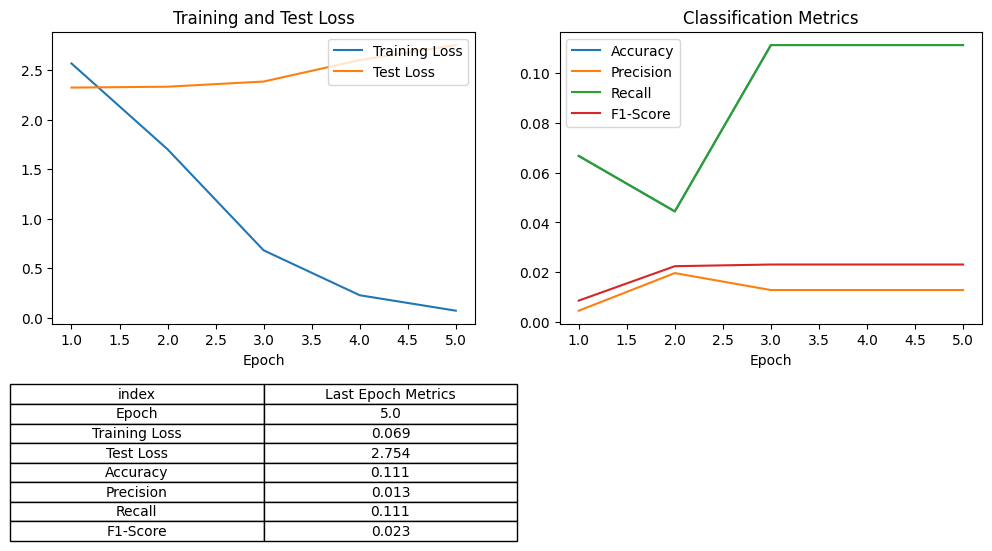

Training completed in: 23.36 seconds


In [40]:
# Cell 8: Run training
if __name__ == '__main__':
    train_model()

In [41]:
# train loader
train_loader = DataLoader(train_hdc_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
val_loader = DataLoader(val_hdc_dataset, batch_size=batch_size, shuffle=False, num_workers=6)

# Initialize the model, loss function, and optimizer
model = HDCNNClassifier(dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Initial learning rate

# Set up an exponential decay with a factor of 0.9 (decay rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

start_time = time.time()

metrics = pd.DataFrame(columns=['Epoch', 'Training Loss', 'Test Loss', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for batch_idx, (inputs_hdc, inputs_cnn, labels) in enumerate(train_loader):
        inputs_hdc, inputs_cnn, labels = inputs_hdc.to(device), inputs_cnn.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs_hdc, inputs_cnn)
        predicted_classes = torch.argmax(outputs, dim=1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.6f}')

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_loss:.6f}')

    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        val_loss = 0
        all_labels = []
        all_preds = []
        for inputs_hdc, inputs_cnn, labels in val_loader:
            inputs_hdc, inputs_cnn, labels = inputs_hdc.to(device), inputs_cnn.to(device), labels.to(device)
            outputs = model(inputs_hdc, inputs_cnn)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        accuracy = correct / total
        precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)

        metrics.loc[len(metrics)] = {'Epoch': epoch+1, 'Training Loss': avg_loss, 'Test Loss': avg_val_loss, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1_score}
        
        # Clear the previous output in the notebook
        clear_output(wait=True)

        # Create a figure with 3 axes: 2 for the plots, 1 for the table below the first plot
        fig, axs = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'height_ratios': [2, 1]})

        # Plot training and test loss on the top-left axis
        metrics.plot(x='Epoch', y=['Training Loss', 'Test Loss'], ax=axs[0, 0])
        axs[0, 0].set_title("Training and Test Loss")

        # Plot accuracy, precision, recall, and F1-score on the top-right axis
        metrics.plot(x='Epoch', y=['Accuracy', 'Precision', 'Recall', 'F1-Score'], ax=axs[0, 1])
        axs[0, 1].set_title("Classification Metrics")

        # Remove legends from the plots for a cleaner look
        axs[0, 0].legend(loc='upper right')
        axs[0, 1].legend(loc='upper left')

        # Hide the axis below the left plot (used for the table)
        axs[1, 0].axis("off")

        # Convert the last row of metrics to a table format, rounded to three decimals
        last_metrics = metrics.iloc[[-1]].round(3).T  # Select the last row, round, and transpose for display
        last_metrics.columns = ['Last Epoch Metrics']  # Rename column for clarity
        last_metrics = last_metrics.reset_index()  # Reset index to remove the index label

        # Add the table to the bottom-left axis
        table = axs[1, 0].table(cellText=last_metrics.values,
                                colLabels=last_metrics.columns,
                                cellLoc='center',
                                loc='center')

        # Customize the table for better readability
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.5)  # Adjusts the width and height of the cells

        # Hide the empty bottom-right plot area for a cleaner look
        axs[1, 1].axis("off")

        # Adjust layout
        plt.subplots_adjust(hspace=0.3, bottom=0.25)
        plt.show()
        plt.close(fig)  # Close figure to free up memory

end_time = time.time()
print(f"Training completed in: {end_time - start_time:.2f} seconds")

KeyboardInterrupt: 